# **Medical Cost Prediction --- Can we accurately predict medical costs based on people’s data?**

# Introduction

Health issues can arise suddenly and unexpectedly, leading to a lot of stress for those affected. Financial stress is a big part of that; healthcare in the United States is expensive, and an issue can quickly leave a person or family running low on money. Insurance companies exist to mitigate these concerns by using financial capital to reimburse those who find themselves in such a scenario (1, 2). However, insurance companies need to collect more than they spend on the medical care of their beneficiaries to not lose money themselves. To do that, they use historical data to sufficiently and precisely measure the amount of the medical costs covered by the insurance charges of each beneficiary (1, 2). The medical insurers' main job is to correctly anticipate insurance policy costs, develop accurate pricing models, plan a particular insurance outcome, and manage an extensive portfolio based on their data analysis of individual insurance records (1).

Our dataset "Insurance.csv" is taken from Kaggle, and it contains 1,339 insurance records from the past, including age, gender, family status, Body Mass Index, smoking or not, etc. We will train a multiple linear regression model that generates the target individual medical charges more accurately with various factors influencing an individual's health status as model inputs. Additionally, we will determine what the most correlated variables influencing insurance costs are. Our final objective is to predict insurance charges based on our fitted model from the training set using the test set. According to our results, the insurance company can then set the price of yearly premiums higher or lower.

In [1]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(funModeling) 
library(Hmisc)
library(GGally)
library(car)
library(janitor)
library(scales)
library(car)
library(glmnet)
library(Metrics)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


funModeling v.1.9.4 :)
Examples and tutorials at livebook.datascienceheroes.com
 / Now in Spanish: librovivodecienciadedatos.ai

Registered S3 method overwritten by 'GGally':
  method fr

ERROR: Error in library(glmnet): there is no package called ‘glmnet’


In [ ]:
install.packages('Metrics')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [ ]:
data<- read.csv("https://raw.githubusercontent.com/Zibo-S/STAT301_GP_4/main/insurance.csv", header= TRUE)

In [ ]:
data%>%head(3)

,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,female,27.90,0,yes,southwest,16884.924
2,18,male,33.77,1,no,southeast,1725.552
3,28,male,33.00,3,no,southeast,4449.462


## Methods: Plan

### **Maybe look into log regression because prices might increase a % based on factors instead of linearly**

We plan to use LASSO to fit a linear regression to predict the charges someone might have to pay given different parameters. Because we are using LASSO(3) to find the most accurate model, we do not know what these parameters will be, but we know that they will be a subset of the ones mentioned earlier.

We can then quantify the model's performance by calculating the mean squared error (MSE) that it achieves on the training set. With this, we expect to achieve a model capable of predicting the charges of a patient, which can give more insight into what factors influence charges the most and allow patients to predict the average price that they might have to pay for a visit to the hospital.

**1. split data into training and testing sets (70% vs 30%)**

In [ ]:
# split data into training and testing sets
set.seed(1234)

data$ID <- 1:nrow(data)
training_set <- sample_n(data, size = nrow(data) * 0.70,
  replace = FALSE
)

testing_set <- anti_join(data,
  training_set,
  by = "ID"
)

head(training_set, 3)
nrow(training_set)

head(testing_set, 3)
nrow(testing_set)

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,32,male,28.12,4,yes,northwest,21472.479,1308
2,26,female,34.20,2,no,southwest,3987.926,1018
3,23,female,42.75,1,yes,northeast,40904.200,1125


[1] 936

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,28,male,33.00,3,no,southeast,4449.462,3
2,32,male,28.88,0,no,northwest,3866.855,5
3,37,female,27.74,3,no,northwest,7281.506,8


[1] 402

Check data balancing for our target variable Charges by histogram.

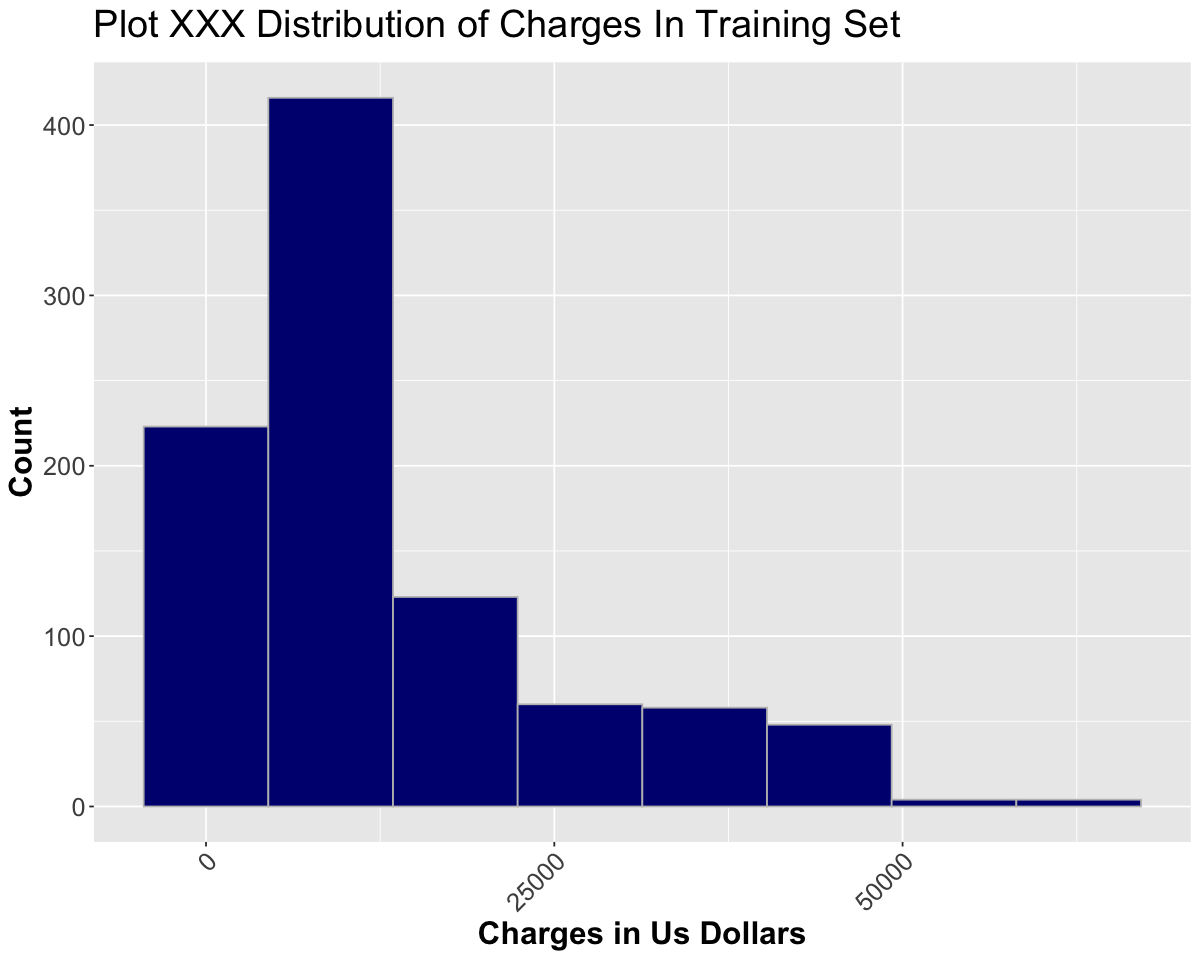

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8)
hist_charges <- ggplot(training_set, aes(x = charges)) +
  geom_histogram(bins = 8, color = "gray", fill = "navyblue") +
  xlab("Charges in Us Dollars") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )+ 
  ggtitle(expression("Plot XXX Distribution of Charges In Training Set"))
hist_charges

As we can see, there are less count for chargers over $25000, which make sense, since less people are being charged for higher amount.

**2. Perform Data tranformation to the training dataset**

In this project, a `log-transformation` is performed to all the numeric variables, for the purpose of reduces or removes the skewness of our training data.<br>
Since glmnet cannot handle categorical variables directly, transferring categorical variables to a binary representation. 

In [ ]:
# drop feature 'ID' since it is irrelevant to our target
training_set=training_set[-8]

In [ ]:
tran_training_set<- training_set %>% mutate(age = log(age),
                                            sex = factor(sex),
                                            bmi = log(bmi),
                                            smoker = factor(smoker),
                                            region = factor(region),
                                            charges = log(charges),
                                           )
# 0 for female and 1 for male
levels(tran_training_set$sex) <- c(0,1)

# 1 for yes and 0 for no
levels(tran_training_set$smoker) <- c(0,1)

# northeast = 0, northwest = 1,southeast = 2, southwest = 3, 
levels(tran_training_set$region) <- c(0,1,2,3)

tran_training_set%>%head(5)

,age,sex,bmi,children,smoker,region,charges
,<dbl>,<fct>,<dbl>,<int>,<fct>,<fct>,<dbl>
1,3.465736,1,3.336481,4,1,1,9.974527
2,3.258097,0,3.532226,2,0,3,8.291027
3,3.135494,0,3.755369,1,1,0,10.618988
4,3.871201,1,3.387774,0,0,3,9.963273
5,3.891820,0,3.058707,1,0,3,9.125019


In [ ]:
tran_training_set<- tran_training_set %>% mutate(sex = as.integer(sex),
                                            smoker = as.integer(smoker),
                                            region = as.integer(region)
                                           )

In [ ]:
tran_training_set%>%head(5)

,age,sex,bmi,children,smoker,region,charges
,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<dbl>
1,3.465736,2,3.336481,4,2,2,9.974527
2,3.258097,1,3.532226,2,1,4,8.291027
3,3.135494,1,3.755369,1,2,1,10.618988
4,3.871201,2,3.387774,0,1,4,9.963273
5,3.891820,1,3.058707,1,1,4,9.125019


Check data balancing again using transfered target variable Charges by histogram.

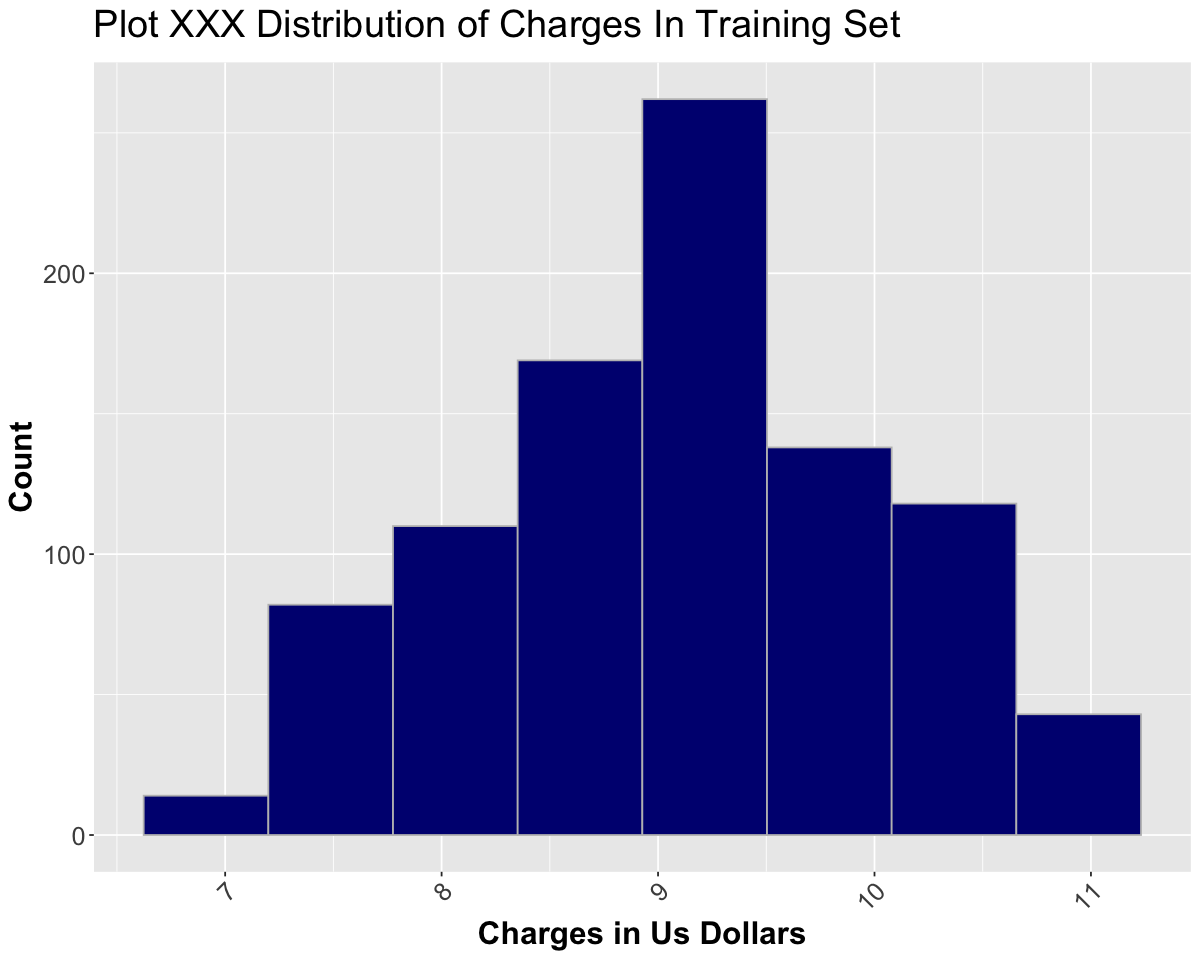

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8)
hist_tran_charges <- ggplot(tran_training_set, aes(x = charges)) +
  geom_histogram(bins = 8, color = "gray", fill = "navyblue") +
  xlab("Charges in Us Dollars") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )+ 
  ggtitle(expression("Plot XXX Distribution of Charges In Training Set"))
hist_tran_charges

From the plot above, the distribution of our transferred target variable is more Normally distributed.

**3. Model Selection by using Lasso**

10 fold cross-validation is carried out to find the best model

Code Reference: <br>
https://stats.stackexchange.com/questions/72251/an-example-lasso-regression-using-glmnet-for-binary-outcome

In [ ]:
set.seed(1234)
x_train <-model.matrix(tran_training_set$charges~tran_training_set$age+tran_training_set$sex+tran_training_set$bmi+tran_training_set$children+tran_training_set$smoker+tran_training_set$region)[,-1]
lasso_model = cv.glmnet(x=x_train,y =tran_training_set$charges,alpha=1, nfolds=10)
lasso_model


Call:  cv.glmnet(x = x_train, y = tran_training_set$charges, nfolds = 10,      alpha = 1) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.00212    62  0.2115 0.01278       6
1se 0.04569    29  0.2231 0.01361       4

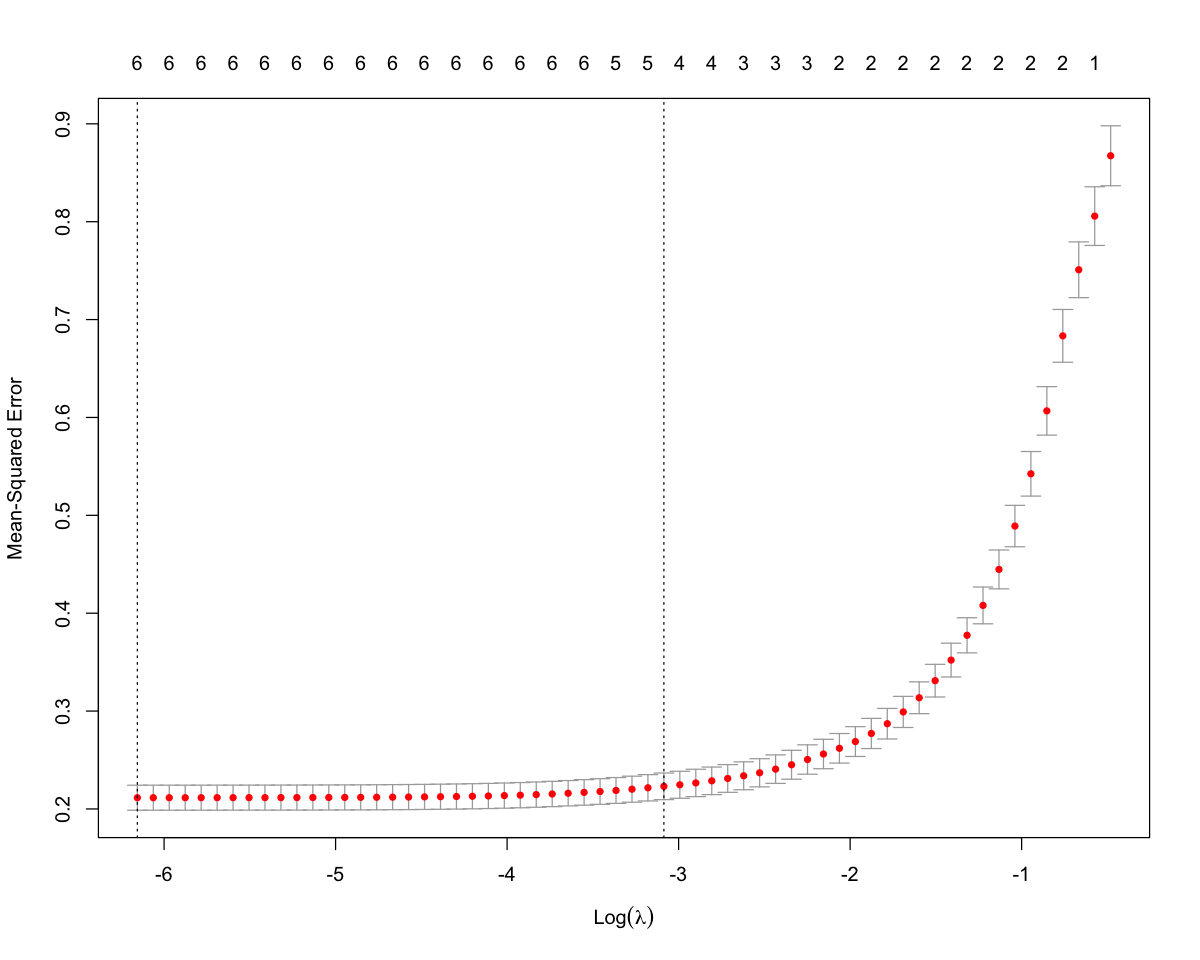

In [ ]:
plot(lasso_model)

In [ ]:
best_lambda <- lasso_model$lambda.min
best_lambda

[1] 0.002120854

Making a new Lasso model with the minimized lambda

In [ ]:
best_model<-glmnet(x=x_train,y =tran_training_set$charges,alpha=1, lambda=best_lambda)

In [ ]:
set.seed(1234) # do not change this
beta_lasso<-lasso_model%>%coef(s = best_lambda)
beta_lasso

7 x 1 sparse Matrix of class "dgCMatrix"
                                    s1
(Intercept)                 1.62864375
tran_training_set$age       1.24950954
tran_training_set$sex      -0.06506625
tran_training_set$bmi       0.35825539
tran_training_set$children  0.08949196
tran_training_set$smoker    1.56928285
tran_training_set$region   -0.04862578

In [ ]:
# tidy the model to a more readable formet
best_model


Call:  glmnet(x = x_train, y = tran_training_set$charges, alpha = 1,      lambda = best_lambda) 

  Df  %Dev   Lambda
1  6 75.92 0.002121

In [ ]:
lasso_variables_vif<-vif(lm(tran_training_set$charges ~.,tran_training_set))
lasso_variables_vif

age      sex      bmi children   smoker   region 
1.025956 1.014189 1.062107 1.020405 1.008187 1.046335

The `lasso_variables_vif` does not indicate a very concerning presence of multicollinearity. 

In [ ]:
# to do: model explination 

**4. Predict on testing set**

4.1 feature transformation on testing set

In [ ]:
testing_set%>%head(3)

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,28,male,33.00,3,no,southeast,4449.462,3
2,32,male,28.88,0,no,northwest,3866.855,5
3,37,female,27.74,3,no,northwest,7281.506,8


In [ ]:
testing_set=testing_set[-8]

tran_testing_set<- testing_set %>% mutate(age = log(age),
                                            sex = factor(sex),
                                            bmi = log(bmi),
                                            smoker = factor(smoker),
                                            region = factor(region),
                                            charges = log(charges),
                                           )
# 0 for female and 1 for male
levels(tran_testing_set$sex) <- c(0,1)

# 1 for yes and 0 for no
levels(tran_testing_set$smoker) <- c(0,1)

# northeast = 0, northwest = 1,southeast = 2, southwest = 3, 
levels(tran_testing_set$region) <- c(0,1,2,3)


tran_testing_set<- tran_testing_set %>% mutate(sex = as.integer(sex),
                                            smoker = as.integer(smoker),
                                            region = as.integer(region)
                                           )

tran_testing_set%>%head(5)

,age,sex,bmi,children,smoker,region,charges
,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<dbl>
1,3.332205,2,3.496508,3,1,3,8.400538
2,3.465736,2,3.363149,0,1,2,8.260197
3,3.610918,1,3.322875,3,1,2,8.893093
4,3.610918,2,3.395515,2,1,1,8.765054
5,4.127134,1,3.269189,0,2,3,10.233105


In [ ]:
x_test <-model.matrix(tran_testing_set$charges~tran_testing_set$age+tran_testing_set$sex+tran_testing_set$bmi+tran_testing_set$children+tran_testing_set$smoker+tran_testing_set$region)[,-1]

predictions<- predict(best_model, newx = x_test, s = "lambda.min")

x_test%>%head(3)

,tran_testing_set$age,tran_testing_set$sex,tran_testing_set$bmi,tran_testing_set$children,tran_testing_set$smoker,tran_testing_set$region
1,3.332205,2,3.496508,3,1,3
2,3.465736,2,3.363149,0,1,2
3,3.610918,1,3.322875,3,1,2


In [ ]:
actual = tran_testing_set$charges
prediction = predictions
mse(actual,prediction)

[1] 0.1665267

In [ ]:
# Testing mse is smaller

**5. OLR for comparison**

In [ ]:
olr<-lm(tran_training_set$charges ~.,tran_training_set)

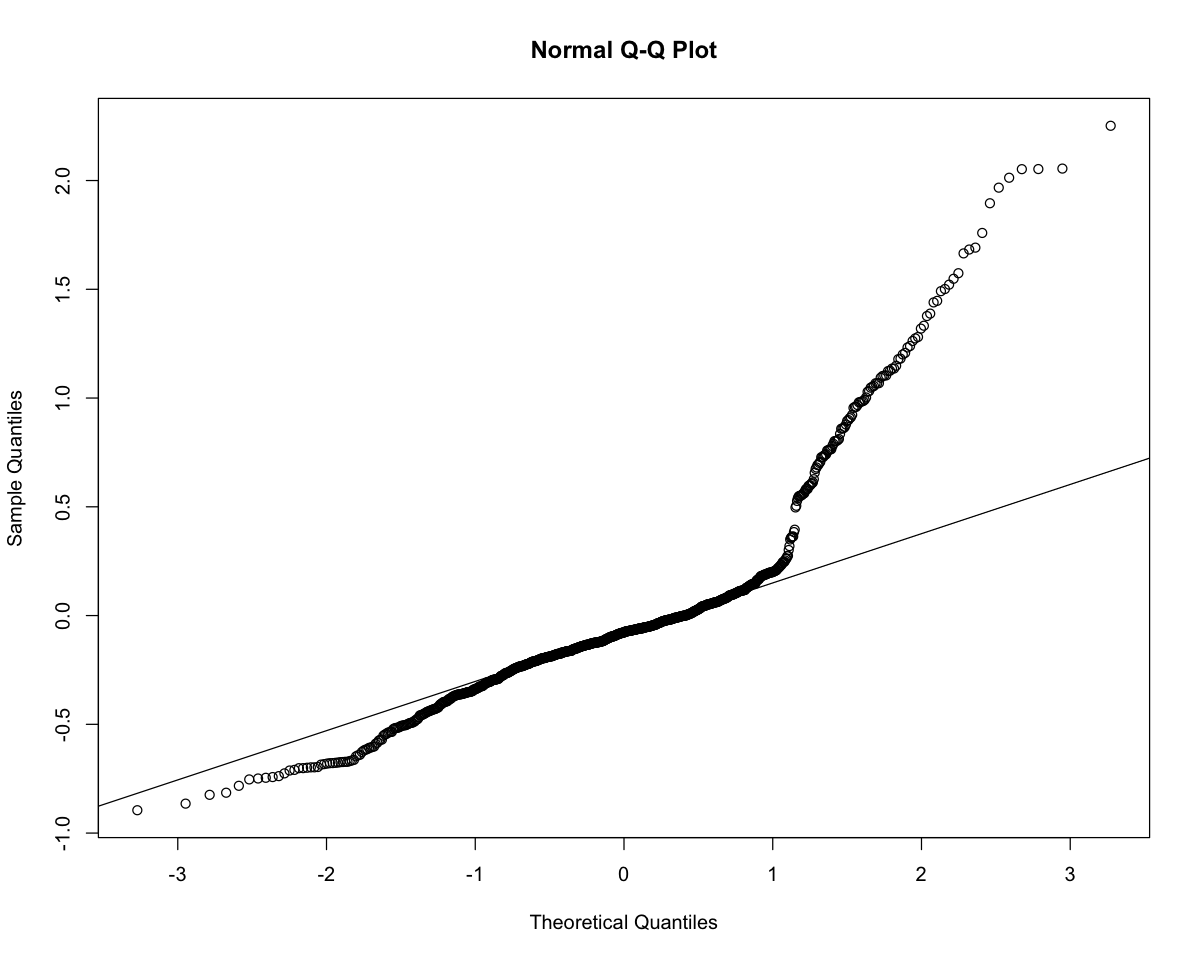

In [ ]:
qqnorm(olr$residuals)
qqline(olr$residuals)

In [ ]:
prediction_olr<- predict(olr, newx = x_test)

actual = tran_testing_set$charges
prediction = prediction_olr

mse(actual,prediction)

Warning message in actual - predicted:
“longer object length is not a multiple of shorter object length”


[1] 1.445821

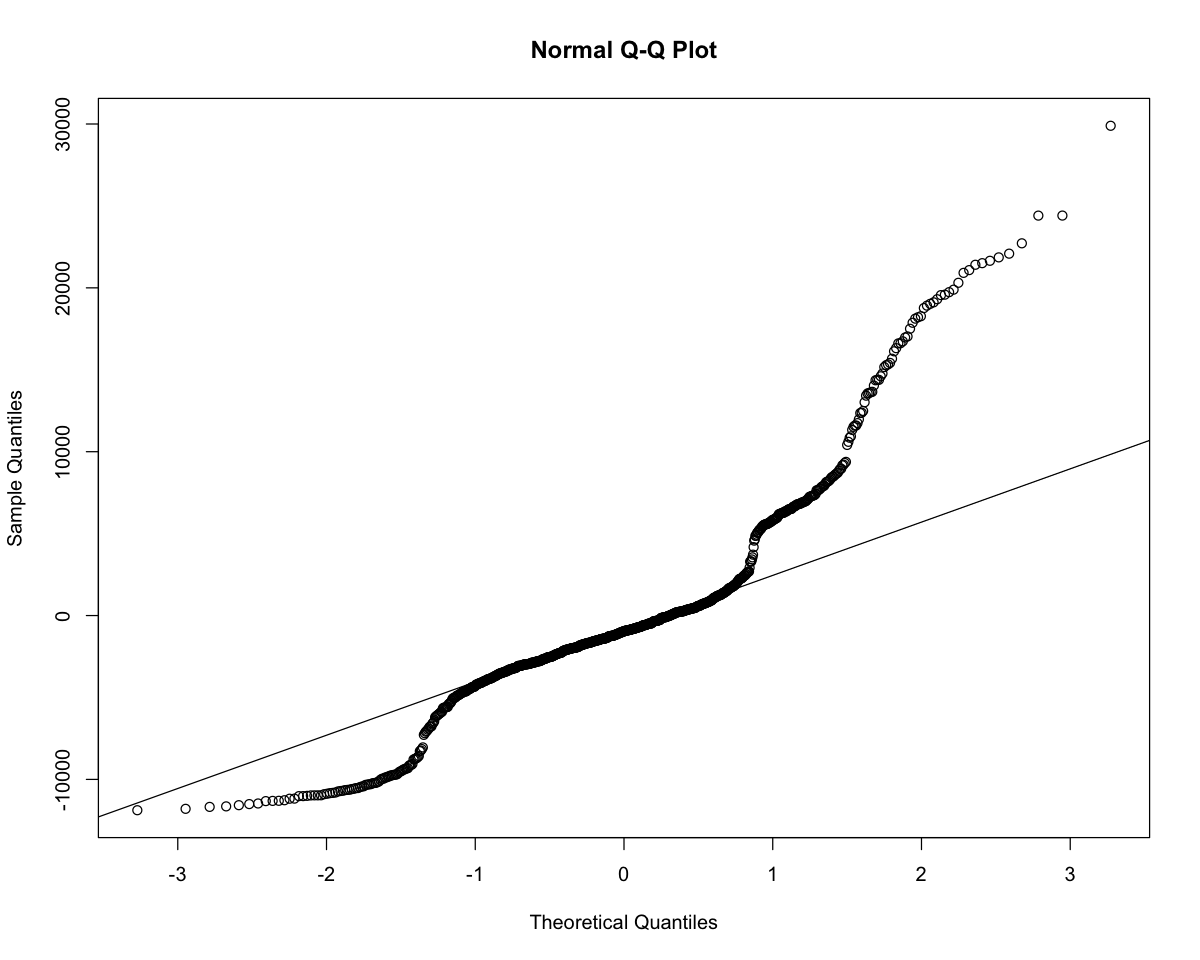

In [ ]:
# non- transformed data 
mlr=lm(training_set$charges~., training_set)
qqnorm(mlr$residuals)
qqline(mlr$residuals)

In [ ]:
prediction_mlr<- predict(mlr, newx = testing_set)

actual = testing_set$charges
prediction = prediction_mlr

mse(actual,predictions)

[1] 288549500

## Ridge_model


Call:  cv.glmnet(x = x_train, y = tran_training_set$charges, nfolds = 10,      alpha = 0) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.06182   100  0.2140 0.01220       6
1se 0.15675    90  0.2253 0.01197       6

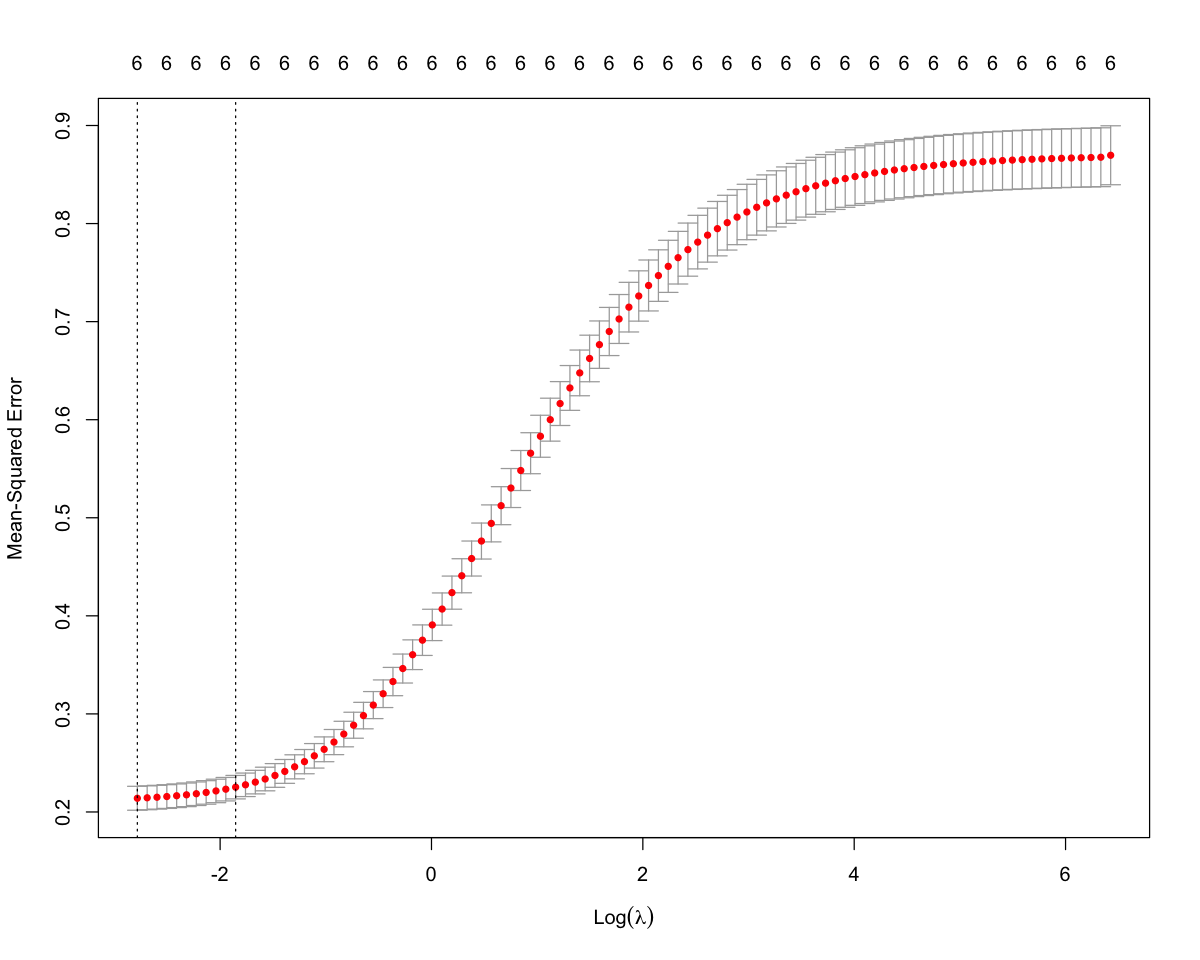

In [ ]:
# ridge
set.seed(1234)
ridge_model = cv.glmnet(x=x_train,y =tran_training_set$charges,alpha=0, nfolds=10)
ridge_model
plot(ridge_model)

In [ ]:
best_lambda_ridge <- ridge_model$lambda.min
best_lambda_ridge

[1] 0.06182403

In [ ]:
set.seed(1234) # do not change this
beta_ridge<-ridge_model%>%coef(s = best_lambda_ridge)
beta_ridge

7 x 1 sparse Matrix of class "dgCMatrix"
                                    s1
(Intercept)                 1.99266720
tran_training_set$age       1.17350800
tran_training_set$sex      -0.06005156
tran_training_set$bmi       0.36230531
tran_training_set$children  0.08837267
tran_training_set$smoker    1.47337829
tran_training_set$region   -0.04661342

In [ ]:
best_model_ridge<-glmnet(x=x_train,y =tran_training_set$charges,alpha=0, lambda=best_lambda_ridge)

In [ ]:
prediction_ridge <- predict(best_model_ridge, newx = x_test, s = "lambda.min")

In [ ]:
actual = testing_set$charges
prediction = prediction_ridge

mse(actual,prediction)

[1] 288550405